In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

from pprint import  pprint
from fake_useragent import  UserAgent
from src.data_fetcher.client import  PriceHistory
from sklearn.preprocessing import  StandardScaler

# Set display options for  pandas
pd.set_option('display.max_colwidth', 1)
pd.set_option('expand_frame_repr', False)

## Fetching and Loading Data

In [2]:
# Define the symbols
symbols = ['AAPL', 'MSFT', 'TSLA', 'AMZN']

# Grab number of stocks in portfolio
number_of_stocks = len(symbols)

# If no data is available, grab it from the NASDAQ.
if not pathlib.Path('src/data/stock_data.csv').exists():
    # Initialize PriceHistory Client
    price_history_client = PriceHistory(symbols=symbols, user_agent=UserAgent().chrome)
    # Grab and dump data in to a csv file.
    price_history_client.price_data_frame.to_csv('src/data/stock_data.csv', index=False)
    pprint(price_history_client.price_data_frame)
    
    # store dataframe in variable
    price_df: pd.DataFrame = price_history_client.price_data_frame
    
else:
    # load the existing CSV file
    price_df: pd.DataFrame = pd.read_csv('src/data/stock_data.csv')
    
display(price_df.head())

,date,close,volume,open,high,low,symbol
0,2025-04-03,178.41,95553620,182.995,184.13,176.920,AMZN
1,2025-04-02,196.01,53679200,187.660,198.34,187.660,AMZN
2,2025-04-01,192.17,41267320,187.860,193.93,187.200,AMZN
3,2025-03-31,190.26,63547560,188.190,191.33,184.400,AMZN
4,2025-03-28,192.72,52548230,198.420,199.26,191.881,AMZN


In [3]:
# Grab important columns
price_df = price_df[['date', 'symbol', 'close']]

# Pivot dataframe to make symbols headers
price_df = price_df.pivot(index='date', columns='symbol', values='close')

display(price_df.head())

symbol,AAPL,AMZN,MSFT,TSLA
date,,,,
2024-10-07,221.69,180.80,409.54,240.83
2024-10-08,225.77,182.72,414.71,244.50
2024-10-09,229.54,185.17,417.46,241.05
2024-10-10,229.04,186.65,415.84,238.77
2024-10-11,227.55,188.82,416.32,217.80


## Calculating Sharpe Ratio and Other Metrics

In [4]:
# Calculate log returns
log_return = np.log(1 + price_df.pct_change())

# Generate random weights and rebalance so that they sum up to 1
random_weights = np.array(np.random.random(number_of_stocks))
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate expected returns annualized
exp_ret = np.dot(log_return.mean(), rebalance_weights) * 252

# Calculate expected volatility annualized
exp_vol  = np.sqrt(
    np.dot(rebalance_weights.T, np.dot(log_return.cov() * 252, rebalance_weights))
)
# Calculate Sharpe Ratio.
sharpe_ratio = (exp_ret - .02)/ exp_vol

In [5]:
weights_df = pd.DataFrame(data={
    'random_weights':random_weights,
    'rebalance_weights':rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print(weights_df)
print('-'*80)

metrics_df = pd.DataFrame(data={
    'Expected Portfolio Return': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])
print('')
print('='*80)
print('PORTFOLIO METRICS:')
print(metrics_df)
print('-'*80)



PORTFOLIO WEIGHTS:
   random_weights  rebalance_weights
0  0.919927        0.391106         
1  0.133768        0.056871         
2  0.982743        0.417813         
3  0.315676        0.134210         
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
   Expected Portfolio Return  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0 -0.123471                   0.251715                      -0.569976              
--------------------------------------------------------------------------------


## Monte Carlo Simulation

In [6]:
# Number of simulations
num_of_simulations = 3000

all_weights = np.zeros((num_of_simulations, number_of_stocks))

return_arr = np.zeros(num_of_simulations)

vol_arr = np.zeros(num_of_simulations)

sharpe_arr = np.zeros(num_of_simulations)

for idx in range(num_of_simulations):
    weights = np.array(np.random.random(number_of_stocks))
    weights = weights / np.sum(weights)
    
    all_weights[idx,:] = weights
    
    return_arr[idx] = np.dot(log_return.mean(), weights) * 252
    
    vol_arr[idx] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    
    sharpe_arr[idx] = (return_arr[idx] -.01) / vol_arr[idx]
    
simulations_data = [return_arr, vol_arr, sharpe_arr, all_weights]

simulations_df = pd.DataFrame(data=simulations_data).T
simulations_df.columns = ['Returns','Volatility', 'Sharpe Ratio', 'Portfolio Weights']

simulations_df = simulations_df.infer_objects()

print('')
print('='*80)
print('SIMULATIONS DATA:')
print('='*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS DATA:
    Returns  Volatility  Sharpe Ratio                                                                     Portfolio Weights
0 -0.113810  0.247187   -0.500876      [0.4087205528797296, 0.2336143342282283, 0.27180467696716676, 0.0858604359248752]   
1 -0.057878  0.299668   -0.226512      [0.39184370935777324, 0.2530915285189246, 0.13937300513615236, 0.2156917569871498]  
2 -0.069412  0.281908   -0.281695      [0.3896332390912288, 0.3133533849802515, 0.13392691111507576, 0.163086464813444]    
3 -0.006323  0.408202   -0.039986      [0.1041743166474665, 0.0017591501826841268, 0.44144479791534275, 0.4526217352545066]
4 -0.060901  0.320667   -0.221105      [0.0940846611633069, 0.09421395582833368, 0.5300561529222758, 0.28164523008608344]  
--------------------------------------------------------------------------------


## Grab Most Important metrics

In [11]:
# Grab max sharpe ratio
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Get min volatility
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.164772                                                                          
Volatility           0.652458                                                                          
Sharpe Ratio         0.237213                                                                          
Portfolio Weights    [0.014794710112982983, 0.097538310774863, 0.05138809061698427, 0.8362788884951697]
Name: 417, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns             -0.170654                                                                              
Volatility           0.220363                                                                              
Sharpe Ratio        -0.819799                                   

## Visualization

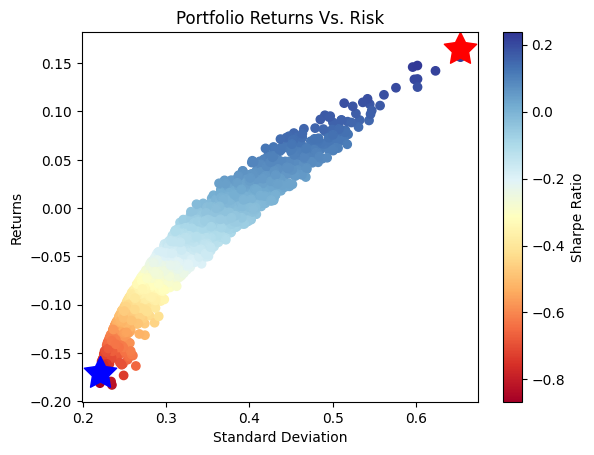

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()